In [1]:
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

dataset_train = '_r3'
dataset_test = '_r4'
dataset_type = 'event'
train_type = 'day'
test_type = 'night'
img_type = 'png'
read_type = read_type = cv2.IMREAD_GRAYSCALE
channel = 1

images_train_f = [f for f in glob.glob('dataset'+dataset_train+'/'+dataset_type+'_'+train_type+'/*.'+img_type)]
images_train = []
images_train_f.sort()

for f in images_train_f:
    img = cv2.imread(f,read_type)
    img = img[:180][:]
    img = cv2.resize(img,dsize=(160,90), interpolation=cv2.INTER_AREA)
    images_train.append(img)

images_test_f = [f for f in glob.glob('dataset'+dataset_test+'/'+dataset_type+'_'+test_type+'/*.'+img_type)]
images_test = []
images_test_f.sort()

for f in images_test_f:
    img = cv2.imread(f,read_type)
    img = img[:180][:]
    img = cv2.resize(img,dsize=(160,90), interpolation=cv2.INTER_AREA)
    images_test.append(img)

print(len(images_train))
print(len(images_test))

4023
3594


In [2]:
train_x = []
train_y = []

for k, img in enumerate(images_train):
    img_ = cv2.GaussianBlur(img,(3,3),0)
    img_ = img_/255.0
    
    train_x.append(img_)
    train_y.append(k//100)

train_x = np.array(train_x)
train_y = np.array(train_y)

train_x = train_x.reshape(len(train_x), channel, 90, 160)
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).long()

train_x = train_x.cuda()
train_y = train_y.cuda()

print(train_x.shape)
print(train_y.shape)

torch.Size([4023, 1, 90, 160])
torch.Size([4023])


In [3]:
N = int((max(train_y)+1).cpu())
N

41

In [4]:
train = TensorDataset(train_x, train_y)

train_loader = DataLoader(train, batch_size = 64, shuffle = True)

In [5]:
class ENet(nn.Module):
    def __init__(self):
        super(ENet, self).__init__()
        self.conv1 = nn.Conv2d(channel, 6, 5, stride=1, padding=2)
        self.conv1_bn = nn.BatchNorm2d(num_features=6)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(num_features=16)
        self.conv3 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
        self.fc1   = nn.Linear(32*10*22, 2*N)
        self.fc2   = nn.Linear(2*N, int(1.5*N))
        self.fc3   = nn.Linear(int(1.5*N), N)
    def forward(self, x):
        x = self.conv1_bn(F.max_pool2d(F.relu(self.conv1(x)), (2,2)))
        x = self.conv2_bn(F.max_pool2d(F.relu(self.conv2(x)), (2,2)))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        x = x.view(-1, 32*10*22)#32 * 19 * 37)
        x = F.relu(self.fc1(F.dropout(x)))
        x = F.relu(self.fc2(F.dropout(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
model = ENet()
model.cuda()


ENet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=7040, out_features=82, bias=True)
  (fc2): Linear(in_features=82, out_features=61, bias=True)
  (fc3): Linear(in_features=61, out_features=41, bias=True)
)

In [6]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001)
for epoch in range(1000):
    total_loss = 0
    
    for t_x, t_y in train_loader:
        
        t_x, t_y = Variable(t_x), Variable(t_y)
        
        optimizer.zero_grad()
        
        output = model(t_x)
        
        loss = criterion(output, t_y)
        
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.data
        
    if (epoch+1)%1 == 0:
        print(epoch+1, total_loss)

(1, tensor(233.9921, device='cuda:0'))
(2, tensor(233.6332, device='cuda:0'))
(3, tensor(232.9311, device='cuda:0'))
(4, tensor(232.4187, device='cuda:0'))
(5, tensor(231.7509, device='cuda:0'))
(6, tensor(231.0712, device='cuda:0'))
(7, tensor(230.0012, device='cuda:0'))
(8, tensor(228.9477, device='cuda:0'))
(9, tensor(227.4725, device='cuda:0'))
(10, tensor(225.5799, device='cuda:0'))
(11, tensor(224.0505, device='cuda:0'))
(12, tensor(221.8618, device='cuda:0'))
(13, tensor(219.4183, device='cuda:0'))
(14, tensor(216.8050, device='cuda:0'))
(15, tensor(213.3820, device='cuda:0'))
(16, tensor(209.9744, device='cuda:0'))
(17, tensor(205.9915, device='cuda:0'))
(18, tensor(201.9790, device='cuda:0'))
(19, tensor(196.9183, device='cuda:0'))
(20, tensor(192.3395, device='cuda:0'))
(21, tensor(186.4889, device='cuda:0'))
(22, tensor(180.6234, device='cuda:0'))
(23, tensor(174.9195, device='cuda:0'))
(24, tensor(167.8726, device='cuda:0'))
(25, tensor(162.8669, device='cuda:0'))
(26, tens

(208, tensor(10.2412, device='cuda:0'))
(209, tensor(10.4237, device='cuda:0'))
(210, tensor(10.5163, device='cuda:0'))
(211, tensor(9.9757, device='cuda:0'))
(212, tensor(9.2708, device='cuda:0'))
(213, tensor(9.8052, device='cuda:0'))
(214, tensor(9.6192, device='cuda:0'))
(215, tensor(9.5020, device='cuda:0'))
(216, tensor(9.8767, device='cuda:0'))
(217, tensor(9.4326, device='cuda:0'))
(218, tensor(9.6624, device='cuda:0'))
(219, tensor(9.4801, device='cuda:0'))
(220, tensor(9.2621, device='cuda:0'))
(221, tensor(9.5798, device='cuda:0'))
(222, tensor(9.6994, device='cuda:0'))
(223, tensor(9.0633, device='cuda:0'))
(224, tensor(8.2177, device='cuda:0'))
(225, tensor(9.2688, device='cuda:0'))
(226, tensor(9.3578, device='cuda:0'))
(227, tensor(9.0097, device='cuda:0'))
(228, tensor(8.8392, device='cuda:0'))
(229, tensor(8.5064, device='cuda:0'))
(230, tensor(9.5070, device='cuda:0'))
(231, tensor(9.5643, device='cuda:0'))
(232, tensor(8.6657, device='cuda:0'))
(233, tensor(9.2170, d

(418, tensor(4.8642, device='cuda:0'))
(419, tensor(5.3211, device='cuda:0'))
(420, tensor(4.9829, device='cuda:0'))
(421, tensor(4.6705, device='cuda:0'))
(422, tensor(4.4966, device='cuda:0'))
(423, tensor(5.0577, device='cuda:0'))
(424, tensor(4.9790, device='cuda:0'))
(425, tensor(5.1416, device='cuda:0'))
(426, tensor(4.6937, device='cuda:0'))
(427, tensor(5.5385, device='cuda:0'))
(428, tensor(5.0163, device='cuda:0'))
(429, tensor(5.3215, device='cuda:0'))
(430, tensor(4.8929, device='cuda:0'))
(431, tensor(4.9742, device='cuda:0'))
(432, tensor(4.9089, device='cuda:0'))
(433, tensor(5.1277, device='cuda:0'))
(434, tensor(4.8468, device='cuda:0'))
(435, tensor(5.8091, device='cuda:0'))
(436, tensor(5.0297, device='cuda:0'))
(437, tensor(4.9185, device='cuda:0'))
(438, tensor(4.9352, device='cuda:0'))
(439, tensor(4.4407, device='cuda:0'))
(440, tensor(4.7023, device='cuda:0'))
(441, tensor(4.7957, device='cuda:0'))
(442, tensor(4.9668, device='cuda:0'))
(443, tensor(4.7629, devi

(629, tensor(3.1996, device='cuda:0'))
(630, tensor(3.5140, device='cuda:0'))
(631, tensor(3.5088, device='cuda:0'))
(632, tensor(3.6629, device='cuda:0'))
(633, tensor(3.7952, device='cuda:0'))
(634, tensor(3.5366, device='cuda:0'))
(635, tensor(3.6475, device='cuda:0'))
(636, tensor(3.1866, device='cuda:0'))
(637, tensor(3.2695, device='cuda:0'))
(638, tensor(3.2853, device='cuda:0'))
(639, tensor(3.1197, device='cuda:0'))
(640, tensor(3.3836, device='cuda:0'))
(641, tensor(3.3697, device='cuda:0'))
(642, tensor(3.2365, device='cuda:0'))
(643, tensor(3.3188, device='cuda:0'))
(644, tensor(3.2337, device='cuda:0'))
(645, tensor(3.2316, device='cuda:0'))
(646, tensor(3.0733, device='cuda:0'))
(647, tensor(3.3574, device='cuda:0'))
(648, tensor(3.3836, device='cuda:0'))
(649, tensor(3.6446, device='cuda:0'))
(650, tensor(3.3472, device='cuda:0'))
(651, tensor(3.4870, device='cuda:0'))
(652, tensor(3.4269, device='cuda:0'))
(653, tensor(3.2445, device='cuda:0'))
(654, tensor(2.8222, devi

(840, tensor(2.9087, device='cuda:0'))
(841, tensor(2.6479, device='cuda:0'))
(842, tensor(2.5729, device='cuda:0'))
(843, tensor(2.4296, device='cuda:0'))
(844, tensor(2.4950, device='cuda:0'))
(845, tensor(2.9352, device='cuda:0'))
(846, tensor(2.9246, device='cuda:0'))
(847, tensor(2.7943, device='cuda:0'))
(848, tensor(2.7519, device='cuda:0'))
(849, tensor(2.7179, device='cuda:0'))
(850, tensor(2.8161, device='cuda:0'))
(851, tensor(2.9174, device='cuda:0'))
(852, tensor(2.7005, device='cuda:0'))
(853, tensor(2.8654, device='cuda:0'))
(854, tensor(2.5304, device='cuda:0'))
(855, tensor(2.8759, device='cuda:0'))
(856, tensor(2.5138, device='cuda:0'))
(857, tensor(2.4599, device='cuda:0'))
(858, tensor(2.7207, device='cuda:0'))
(859, tensor(2.5694, device='cuda:0'))
(860, tensor(2.4803, device='cuda:0'))
(861, tensor(2.2631, device='cuda:0'))
(862, tensor(2.4355, device='cuda:0'))
(863, tensor(2.7464, device='cuda:0'))
(864, tensor(2.7818, device='cuda:0'))
(865, tensor(2.3718, devi

In [7]:
test_x = []
test_y = []

for k, img in enumerate(images_test):
    if k%1 != 0:
        continue
    img_ = cv2.GaussianBlur(img,(3,3),0)
    img_ = img_/255.0
    test_x.append(img_)
    test_y.append(0)

test_x = np.array(test_x)
test_y = np.array(test_y)

test_x = test_x.reshape(len(test_x), channel, 90, 160)

test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).long()

test_x = test_x.cuda()
test_y = test_y.cuda()

print(test_x.shape)
print(test_y.shape)

torch.Size([3594, 1, 90, 160])
torch.Size([3594])


In [8]:
test_x, test_y = Variable(test_x), Variable(test_y)

result_test = model(test_x).data
global_max_value = torch.max(result_test, 1)[0]
global_max_index = torch.max(result_test, 1)[1]
global_max_value = global_max_value.cpu().numpy()
global_max_index = global_max_index.cpu().numpy()
test_y = test_y.cpu().numpy()



result_test = result_test.cpu().numpy()

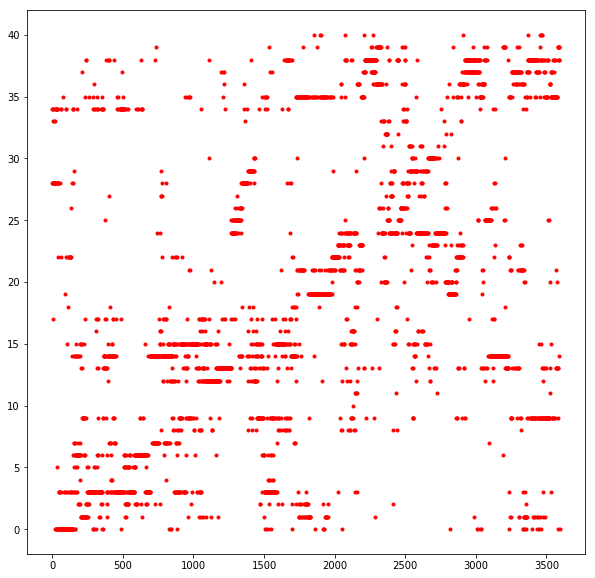

In [9]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(global_max_index,'r.')
plt.show()

In [10]:
p = np.exp(result_test)
global_max_value = np.exp(global_max_value)    

In [34]:
match_result = []
acc = []
precision = []
recall = []
len_Q = len(p)
len_D = N
lost = True
position = -1
th1 = 0.99
th2 = 0.0001
K = 1

R = range(0,26)
for i in range(len(R)):
    R[i] /= 25.0
    

TP = []
TN = []
FP = []
FN = []
FX = []

for th1 in R:
    #for th2 in R:
        for i in range(len_Q):
            if lost:
                if global_max_value[i] < th1:
                    match_result.append(-1)
                    lost = True
                else:
                    match_result.append(global_max_index[i])
                    lost = False
                    position = global_max_index[i]
            else:
                left = max(position-K,0)
                right = min(position+K+1,len_D-1)
                local_max_value = max(p[i][left:right])
                local_max_index = p[i][left:right].argmax() + left
                if local_max_value < th2:

                    if global_max_value[i] < th1:
                        match_result.append(-1)
                        lost = True
                    else:
                        match_result.append(global_max_index[i])
                        position = global_max_index[i]
                        lost = False
                else:
                    match_result.append(local_max_index)
                    position = local_max_index
                    lost = False
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        fx = 0
        for i in range(len_Q):
            if i > 3594:
                if match_result[i] == -1:
                    tn+=1
                else:
                    fp+=1
            else:
                if (((N/3594.0)*i+5) > match_result[i]) and (((N/3594.0)*i-5) < match_result[i]):
                    tp+=1
                elif match_result[i] == -1:
                    fn+=1
                else:
                    fx+=1

        TP.append(tp)
        TN.append(tn)
        FP.append(fp)
        FN.append(fn)
        FX.append(fx)
        precision.append((tp+0.001)/(tp+fp+fx*0.5+0.001))
        recall.append((tp+0.001)/(tp+fn+fx*0.5+0.001))
        acc.append((tp+tn)/float(fp+fn+tp+tn+fx))
        match_result = []
print(acc[:].index(max(acc[:])))
print(max(acc))

15
0.520311630495


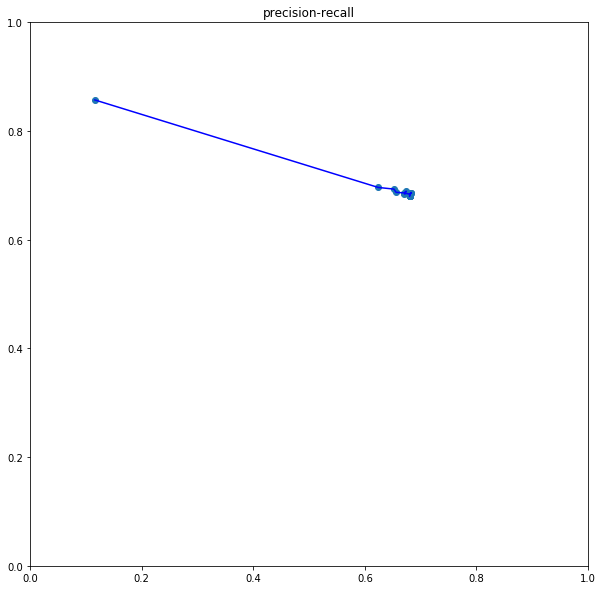

[0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.681, 0.681, 0.681, 0.68, 0.682, 0.683, 0.682, 0.678, 0.675, 0.671, 0.674, 0.67, 0.656, 0.652, 0.624, 0.116]
[0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.681, 0.681, 0.681, 0.682, 0.685, 0.686, 0.685, 0.684, 0.685, 0.684, 0.689, 0.686, 0.687, 0.693, 0.696, 0.857]


In [35]:
axes = plt.gca()
axes.set_ylim([0,1])
axes.set_xlim([0,1])
plt.title("precision-recall")
for i in range(len(precision)):
    precision[i] = round(precision[i],3)
    recall[i] = round(recall[i],3)
plt.scatter(recall,precision)
plt.plot(recall,precision,'b')
plt.show()
print(recall)
print(precision)

In [28]:
match_result = []
acc = []
precision = []
recall = []
len_Q = len(p)
len_D = N
lost = True
position = -1
th1 = 0.99
th2 = 0.00001
K = 1

for i in range(len_Q):
    if lost:
        if global_max_value[i] < th1:
            match_result.append(-1)
            lost = True
        else:
            match_result.append(global_max_index[i])
            lost = False
            position = global_max_index[i]
    else:
        left = max(position-K,0)
        right = min(position+K+1,len_D-1)
        local_max_value = max(p[i][left:right])
        local_max_index = p[i][left:right].argmax() + left
        if local_max_value < th2:

            if global_max_value[i] < th1:
                match_result.append(-1)
                lost = True
            else:
                match_result.append(global_max_index[i])
                position = global_max_index[i]
                lost = False
        else:
            match_result.append(local_max_index)
            position = local_max_index
            lost = False


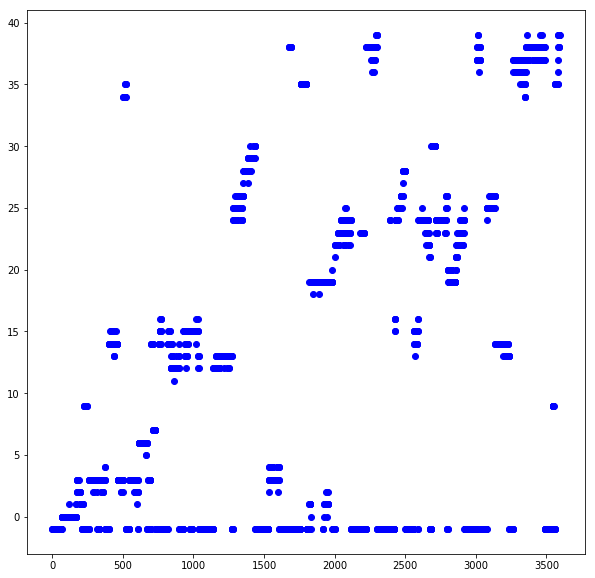

In [29]:
plt.plot(match_result,'bo')
plt.show()

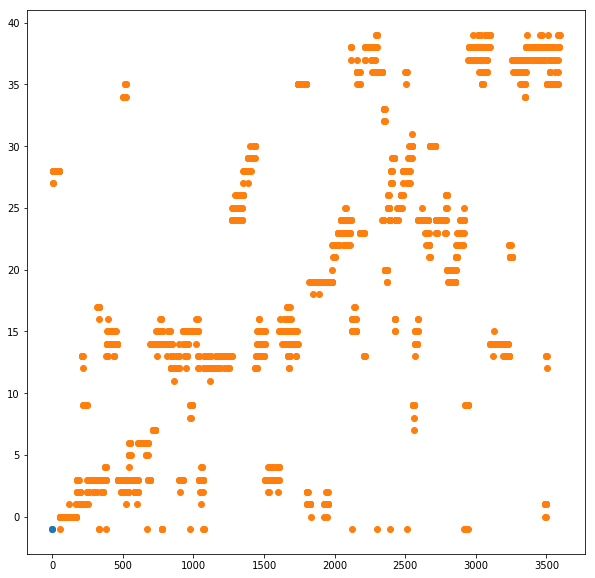

0.000556483027268


In [15]:
acc = 0
Ax = []
Ay = []
Bx = []
By = []
for i in range(len(match_result)):
    #print(match_result[i], 4*i)
    if(((4.0/35.0)*i+3) > match_result[i]) and (((4.0/35.0)*i-3) < match_result[i]):
        acc+=1
        Ax.append(i)
        Ay.append(match_result[i])
    else:
        Bx.append(i)
        By.append(match_result[i])

plt.scatter(Ax,Ay)
plt.scatter(Bx,By)
plt.show()
print(float(acc)/len(match_result))